# Clap Detector
This notebook shows the basic recording and playback features of the Pynq-Z1.  
It uses the audio jack to play back recordings from the built-in microphone, as well as a pre-recorded audio sample. Moreover, visualization with matplotlib and playback with IPython.Audio are shown.
## Create new audio object

In [4]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")
pAudio = base.audio

In [5]:
import zmq
import time

for led in base.leds:
    led.off()
base.leds[0].on()
context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.setsockopt_string(zmq.SUBSCRIBE, '')
socket.connect("tcp://192.168.112.93:5556")
# wait
#msg = socket.recv_string()
sample_time = time.time()
#print(msg)


## Record and play
Record a 3-second sample and save it into a file.

In [6]:
import time

audio_file = "Recording_clap-5.pdm"

#for led in base.leds:
#    led.off()
base.leds[0].on()
#time.sleep(1)
base.leds[1].on()
record_time = time.time()
pAudio.record(4)
pAudio.save(audio_file)
base.leds[0].off()
base.leds[1].off()


### Step 1: Preprocessing
In this step, we first convert the 32-bit integer buffer to 16-bit. Then we divide 16-bit words (16 1-bit samples each) into 8-bit words with 1-bit sample each.

In [7]:
import time
import numpy as np

# pAudio.load("/var/tmp/outfile.wav")
pAudio.load(audio_file)
start = time.time()
af_uint8 = np.unpackbits(pAudio.buffer.astype(np.int16)
                         .byteswap(True).view(np.uint8))
end =  time.time()

print("Time to convert {:,d} PDM samples: {:0.2f} seconds"
      .format(np.size(pAudio.buffer)*16, end-start))
print("Size of audio data: {:,d} Bytes"
      .format(af_uint8.nbytes))

Time to convert 12,288,000 PDM samples: 0.07 seconds
Size of audio data: 12,288,000 Bytes


### Step 2: Converting PDM to PCM
We now convert PDM to PCM by decimation. The sample rate is reduced from 3MHz to 32kHz.

We will remove the first and last 10 samples in case there are outliers introduced by decimation. We will also remove the DC offset from the waveform.

In [8]:
import time
from scipy import signal

start = time.time()
af_dec = signal.decimate(af_uint8,8,zero_phase=True)
af_dec = signal.decimate(af_dec,6,zero_phase=True)
af_dec = signal.decimate(af_dec,2,zero_phase=True)
af_dec = (af_dec[10:-10]-af_dec[10:-10].mean())
end = time.time()
print("Time to convert {:,d} Bytes: {:0.2f} seconds"
      .format(af_uint8.nbytes, end-start))
print("Size of audio data: {:,d} Bytes"
      .format(af_dec.nbytes))
del af_uint8

Time to convert 12,288,000 Bytes: 8.23 seconds
Size of audio data: 1,023,840 Bytes


### Step 3: Audio Playback in Web Browser

In [9]:
#from IPython.display import Audio as IPAudio
#IPAudio(af_dec, rate=32000)

## Plotting PCM data

Users can display the audio data in notebook:

1. Plot the audio signal's amplitude over time.
2. Plot the spectrogram of the audio signal.

#### Amplitude over time

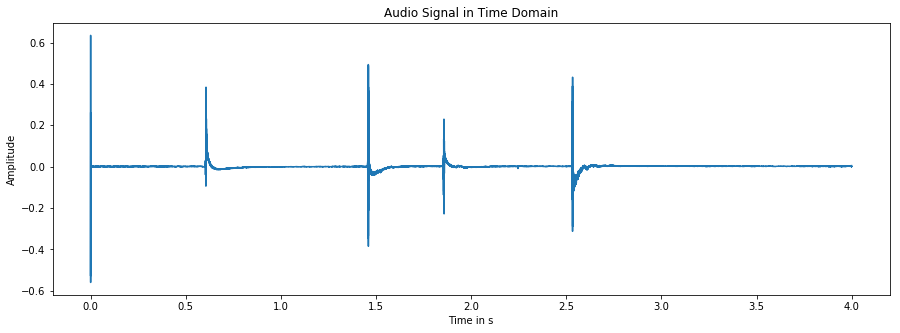

In [10]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt

match = np.array([x for x in range(10000, 0, -8)] + list(itertools.repeat(0, 100)))

plt.figure(num=None, figsize=(15, 5))
time_axis = np.arange(0,((len(af_dec))/32000),1/32000)
plt.title('Audio Signal in Time Domain')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.plot(time_axis, af_dec)
#plt.plot(time_axis[5000:15000], af_dec[5000:15000])
#plt.plot(time_axis[:len(match)], match)
plt.show()

#### Frequency spectrum

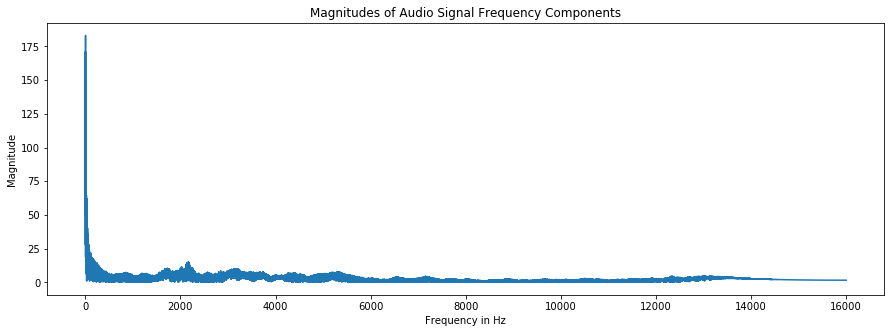

In [11]:
from scipy.fftpack import fft

yf = fft(af_dec)
yf_2 = yf[1:len(yf)//2]
xf = np.linspace(0.0, 32000//2, len(yf_2))

plt.figure(num=None, figsize=(15, 5))
plt.plot(xf, abs(yf_2))
plt.title('Magnitudes of Audio Signal Frequency Components')
plt.xlabel('Frequency in Hz')
plt.ylabel('Magnitude')
plt.show()

#### Frequency spectrum over time
Use the `classic` plot style for better display.

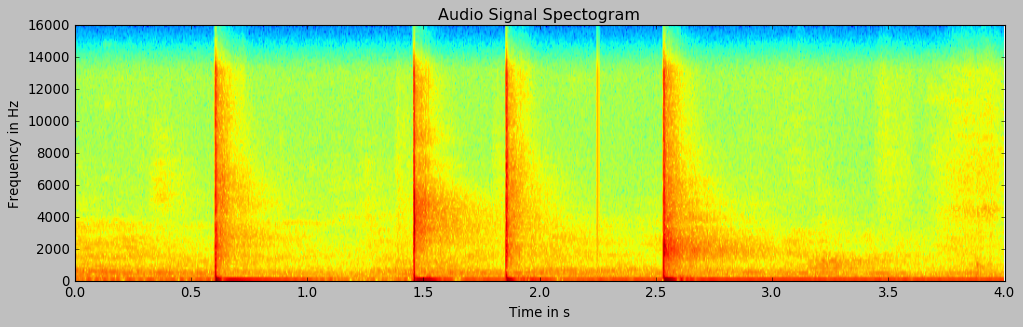

In [12]:
import matplotlib

np.seterr(divide='ignore',invalid='ignore')
matplotlib.style.use("classic")
plt.figure(num=None, figsize=(15, 4))
plt.title('Audio Signal Spectogram')
plt.xlabel('Time in s')
plt.ylabel('Frequency in Hz')
_ = plt.specgram(af_dec, Fs=32000)

### Correlate using matching filter

We use the scipy filter scipy.signal.correlate

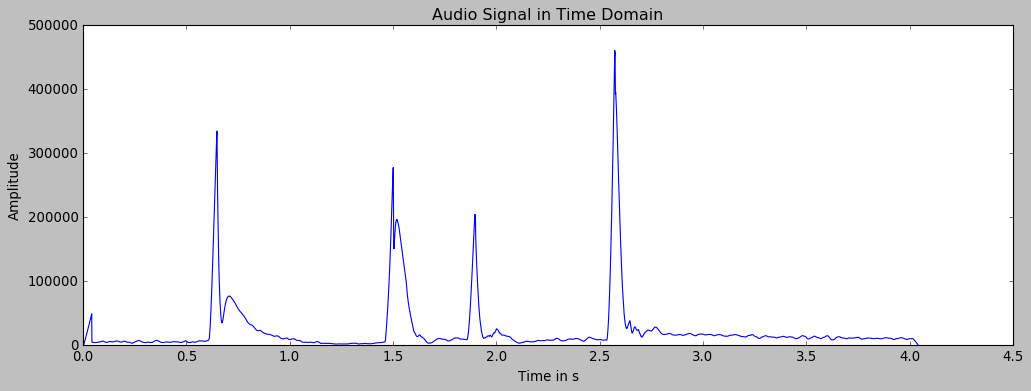

In [13]:
import itertools
from scipy import signal,stats
# create our match pattern in2 in the same N dimensions as in1
# create sail triangle
match = np.array([x for x in range(10000, 0, -8)] + list(itertools.repeat(0, 100)))

# Cross-correlate in1 andin2
corr = signal.correlate(abs(af_dec), match)

plt.figure(num=None, figsize=(15, 5))
time_axis = np.arange(0,((len(corr))/32000),1/32000)
plt.title('Audio Signal in Time Domain')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.plot(time_axis, corr)
plt.show()

In [ ]:
import pickle
import zmq
import json

start = time.time()
lims = stats.describe(corr)
print(lims)
#indexes = detect_peaks(corr, mph=20000, mpd=5000)
indexes = detect_peaks(corr, mph=2*lims.mean, mpd=15000)
elapsed = time.time() - start
dts = indexes/32000
print(elapsed)
print(indexes)
print(dts)
cor_data = dict()
cor_data["192.168.112.95"] = (sample_time, tuple(dts))
print(cor_data)
cor_data_file = "qlnd-{}.p".format(int(sample_time/10))
jsoned_data = json.dumps( cor_data)
print("JSON:", jsoned_data)
jsoned_data = json.dumps( cor_data)
#pickled_data = pickle.dumps( cor_data, protocol=2 )
#pickle.dump( cor_data, open( "qlnd_A.p", "wb" ), protocol=2 )
#fn = "/home/xilinx/jupyter_notebooks/base/audio/"+cor_data_file
#!ls -l "/home/xilinx/jupyter_notebooks/base/audio/{}".format(cor_data_file)
#!scp -o UserKnownHostsFile=/dev/null "/home/xilinx/jupyter_notebooks/base/audio/qlnd_A.p" "carl@192.168.112.76:qlnd_A.p"

port = "5556"

context = zmq.Context()
socket = context.socket(zmq.REQ)
socket.connect("tcp://192.168.112.76:%s" % port)

msg = pickled_data

messagedata = msg
print("%s %s" % ('', messagedata))
socket.send_string("%s %s" % ('', messagedata))

message = socket.recv()

In [ ]:
len(corr)


In [ ]:
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()
